# **Case Study: Real-Time Seismic Temporal–Spatial Hotspot Detection for Proactive Evacuation Routing (STHDR)**


**Real-time Spatio-Temporal Hotspot Detection for Proactive Seismic Response: A Lightweight Pipeline Using USGS Live Data\**

Most seismic studies focus on aftershock statistics, hazard maps, or magnitude prediction. This project emphasizes real-time detection of rapidly emerging seismic hotspots (spatial + temporal clustering) and automatically proposes proactive local evacuation corridors (simple directional corridors away from the densest epicenter). Combining live USGS feeds with quick spatio-temporal clustering + KDE hot-spoting + simple routing suggestions is not common in published case studies and can be valuable for early-warning / municipal planning — especially when integrated with local population & infrastructure layers.

**Case Study Proposal**

Seismic events often cluster in time and space; rapid identification of newly-emerging clusters (hotspots) enables authorities to prioritize inspections and pre-position resources. This study proposes a lightweight, reproducible pipeline that ingests the USGS real-time feed (past 30 days), detects spatio-temporal hotspots using sliding-window spatial clustering and kernel density estimation, ranks hotspots by growth and average magnitude, and generates simple evacuation corridor suggestions directed away from the densest epicenter. The system is designed to run in near-real time in Google Colab or a small server and to be easily extendable with population, building footprint, and road network layers for full operationalization.

**Key contributions:** (1) simple, interpretable hotspot scoring that combines magnitude, event density, and recent growth; (2) real-time corridor suggestion algorithm that points to lower hazard zones; (3) open reproducible code + visual outputs (heatmaps, cluster markers, corridor polylines) ready for field testing.

**Data sources**
*   Live USGS feed (all earthquakes, past 30 days): https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv (used directly)

*   (Optional for publication) Population / building footprint / soil layers for vulnerability overlays (WorldPop, OpenStreetMap, national data) — these are suggested extensions.

In [1]:
try:
    import geopandas as gpd
except Exception:
    # install packages quietly
    !pip install --quiet geopandas folium pyproj shapely scikit-learn scipy branca

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from math import radians, cos, sin, asin, sqrt, atan2, degrees
from sklearn.cluster import DBSCAN
from pyproj import Transformer
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point
import os
from scipy.stats import gaussian_kde

In [4]:
# LOAD LIVE USGS DATA (past 30 days)
URL = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
print("Fetching USGS data")
df = pd.read_csv(URL)
df = df.dropna(subset=['latitude', 'longitude', 'depth', 'mag', 'time'])

Fetching USGS data


In [6]:
# convert time to datetime
df['time_utc'] = pd.to_datetime(df['time'])
# keep only reasonable magnitudes and depths
df = df[(df['mag'] >= 0) & (df['depth'] >= -10)]

print(f"Loaded {len(df)} events from USGS (past ~30 days).")

Loaded 7615 events from USGS (past ~30 days).


In [7]:
# DERIVE FIELDS & SUBSET RECENT WINDOW
# For hotspot detection focus on recent window (e.g., last 7 days)
WINDOW_DAYS = 7
cutoff = pd.Timestamp.utcnow() - pd.Timedelta(days=WINDOW_DAYS)
recent = df[df['time_utc'] >= cutoff].copy().reset_index(drop=True)
print(f"{len(recent)} events in the recent {WINDOW_DAYS}-day window (for hotspot detection).")

1728 events in the recent 7-day window (for hotspot detection).


In [8]:
# SPATIAL CLUSTERING (DBSCAN with Haversine)
# Spatial eps in kilometers, convert to radians for haversine
# Min samples controls cluster sensitivity
def haversine_dbscan(latlons_deg, eps_km=50, min_samples=5):
    """
    Perform DBSCAN using haversine metric. Input latlons_deg as Nx2 [lat,lon] in degrees.
    eps_km: clustering radius in kilometers.
    """
    kms_per_radian = 6371.0088
    coords_rad = np.radians(latlons_deg)
    eps_rad = eps_km / kms_per_radian
    db = DBSCAN(eps=eps_rad, min_samples=min_samples, metric='haversine').fit(coords_rad)
    return db.labels_

In [9]:
# Choose parameters (you can tune)
EPS_KM = 50      # cluster radius (50 km)
MIN_SAMPLES = 4  # at least 4 events to form cluster
recent['cluster'] = haversine_dbscan(recent[['latitude','longitude']].values, eps_km=EPS_KM, min_samples=MIN_SAMPLES)

In [10]:
# label noise as -1; filter clusters
clusters = recent[recent['cluster'] != -1].copy()
cluster_ids = clusters['cluster'].unique().tolist()
print(f"Detected {len(cluster_ids)} spatial cluster(s) in the recent window with eps_km={EPS_KM}.")

Detected 36 spatial cluster(s) in the recent window with eps_km=50.


In [11]:
# SPATIO-TEMPORAL SCORING: hotspot score = f(density, avg_mag, recent_growth)
# density = number of events in cluster / cluster area (approx)
# avg_mag = mean magnitude
# growth = events in last 24h vs previous 48h (if available)
def cluster_centroid(df_cluster):
    return df_cluster['latitude'].mean(), df_cluster['longitude'].mean()

def approx_area_km2(latlons):
    # approximate convex hull area in projected metric (EPSG:3857)
    try:
        import geopandas as gpd
        from shapely.geometry import MultiPoint
        pts = MultiPoint([(lon, lat) for lat, lon in latlons])
        gdf = gpd.GeoSeries([pts])
        # project to meters then compute area
        gdf = gdf.set_crs(epsg=4326).to_crs(epsg=3857)
        area_m2 = gdf[0].convex_hull.area
        return area_m2 / 1e6  # km^2
    except Exception:
        # fallback: use circular area with radius = max distance from centroid
        lats = [p[0] for p in latlons]; lons = [p[1] for p in latlons]
        cen = (np.mean(lats), np.mean(lons))
        # compute max haversine distance
        def hav_km(a,b):  # (lat,lon)
            lat1, lon1 = map(radians, a); lat2, lon2 = map(radians, b)
            dlon = lon2 - lon1; dlat = lat2 - lat1
            a_ = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
            c = 2*asin(sqrt(a_)); km = 6371.0088 * c; return km
        dmax = max(hav_km(cen,(lat,lond)) for lat,lond in zip(lats,lons))
        return np.pi * (dmax**2)

In [12]:
hotspots = []
for cid in cluster_ids:
    group = clusters[clusters['cluster'] == cid]
    n_events = len(group)
    avg_mag = group['mag'].mean()
    centroid = cluster_centroid(group)
    area_km2 = approx_area_km2(list(zip(group['latitude'], group['longitude'])))
    density = n_events / (area_km2 + 1e-6)
    # growth: compare last 24h to preceding 48h
    last24 = group[group['time_utc'] >= (pd.Timestamp.utcnow() - pd.Timedelta(hours=24))]
    prev48 = group[(group['time_utc'] < (pd.Timestamp.utcnow() - pd.Timedelta(hours=24))) &
                   (group['time_utc'] >= (pd.Timestamp.utcnow() - pd.Timedelta(hours=72)))]
    growth_rate = (len(last24) / (len(prev48)+1e-6))
    score = (density * 0.5) + (avg_mag * 1.5) + (growth_rate * 2.0)
    hotspots.append({
        'cluster_id': int(cid),
        'n_events': int(n_events),
        'avg_mag': float(avg_mag),
        'centroid_lat': float(centroid[0]),
        'centroid_lon': float(centroid[1]),
        'area_km2': float(area_km2),
        'density': float(density),
        'growth_rate': float(growth_rate),
        'score': float(score)
    })

In [13]:
hotspots_df = pd.DataFrame(hotspots).sort_values('score', ascending=False).reset_index(drop=True)
print("\nHotspot ranking (top results):")
print(hotspots_df.head(10))


Hotspot ranking (top results):
   cluster_id  n_events   avg_mag  centroid_lat  centroid_lon      area_km2  \
0          15         4  1.945000     41.789675   -119.744475     30.031675   
1          22         6  1.325000     39.656222   -111.553722   1711.943600   
2          10         5  1.596811     65.280995   -150.671371    537.643438   
3          11         4  4.825000      8.798100    -84.075175     61.471305   
4           9         7  4.685714     52.106229    159.830400  10273.229942   
5          35         6  0.818333     41.517139   -112.158389      0.398814   
6           0        18  2.313889     18.003694    -66.853463    992.132486   
7           2        70  1.927857     19.316319   -155.441078  12449.284535   
8          27         7  3.441429     19.137029    -64.547062   1007.870850   
9           1        66  1.740909     31.638000   -104.244561   2461.448949   

     density   growth_rate         score  
0   0.133193  3.000000e+06  6.000003e+06  
1   0.003505

In [14]:
# KERNEL DENSITY ESTIMATION (for heatmap)
def kde_heatmap(latitudes, longitudes, bandwidth=0.1, grid_size=200):
    # project to mercator (meters) for distance-aware KDE using pyproj
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
    xs, ys = transformer.transform(longitudes.values, latitudes.values)
    values = np.vstack([xs, ys])
    kde = gaussian_kde(values, bw_method=bandwidth)
    # build grid
    xmin, ymin = xs.min(), ys.min()
    xmax, ymax = xs.max(), ys.max()
    xi, yi = np.mgrid[xmin:xmax:grid_size*1j, ymin:ymax:grid_size*1j]
    coords = np.vstack([xi.ravel(), yi.ravel()])
    zi = kde(coords)
    # convert back to latlon grid for plotting? we'll use folium heatmap with points
    return xi, yi, zi.reshape(xi.shape)

In [15]:
# For folium heatmap we can pass weighted points: [lat, lon, weight]
heat_points = recent[['latitude','longitude','mag']].values.tolist()

In [16]:
# SIMPLE EVACUATION CORRIDOR GENERATOR
# For each hotspot centroid, suggest a polyline pointing away from centroid
# We choose a direction along the bearing to the nearest lower-density quadrant
# This is a simple heuristic (for demo) — replace with road network routing for production.
def destination_point(lat, lon, bearing_deg, distance_km):
    # Returns destination lat/lon from start point given bearing and distance
    R = 6371.0088
    bearing = radians(bearing_deg)
    lat1 = radians(lat); lon1 = radians(lon)
    lat2 = asin(sin(lat1)*cos(distance_km/R) + cos(lat1)*sin(distance_km/R)*cos(bearing))
    lon2 = lon1 + atan2(sin(bearing)*sin(distance_km/R)*cos(lat1), cos(distance_km/R)-sin(lat1)*sin(lat2))
    return degrees(lat2), degrees(lon2)

In [17]:
def suggest_corridor(centroid_lat, centroid_lon, angle_deg=None, distance_km=50):
    # if angle not provided pick an angle that points to lower event density by sampling bearings
    if angle_deg is None:
        # sample bearings and pick one with lowest count of events in that sector
        bearings = np.arange(0,360,30)
        best_b = None; best_count = 1e9
        for b in bearings:
            # pick a test point 50km away
            tlat, tlon = destination_point(centroid_lat, centroid_lon, b, distance_km)
            # count recent events within 30km of the test point
            def hav_km(a,b_):
                lat1, lon1 = map(radians, a); lat2, lon2 = map(radians, b_)
                dlon = lon2 - lon1; dlat = lat2 - lat1
                aa = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
                c = 2*asin(sqrt(aa)); return 6371.0088*c
            count = sum(1 for _, r in recent.iterrows() if hav_km((r['latitude'], r['longitude']), (tlat, tlon)) < 30)
            if count < best_count:
                best_count = count; best_b = b
        angle_deg = int(best_b)
    # build polyline from centroid to two destinations (near and far) to show corridor
    p1 = (centroid_lat, centroid_lon)
    p2 = destination_point(centroid_lat, centroid_lon, angle_deg, distance_km*0.5)
    p3 = destination_point(centroid_lat, centroid_lon, angle_deg, distance_km)
    return [p1, p2, p3], angle_deg

In [18]:
# compute corridors for top hotspots
corridors = []
for idx, row in hotspots_df.head(5).iterrows():
    poly, bearing = suggest_corridor(row['centroid_lat'], row['centroid_lon'], angle_deg=None, distance_km=60)
    corridors.append({'cluster_id': row['cluster_id'], 'poly': poly, 'bearing': bearing, 'score': row['score']})

In [19]:
# VISUALIZATION (FOLIUM)
# center map on mean location of recent
center = [recent['latitude'].mean(), recent['longitude'].mean()]
m = folium.Map(location=center, zoom_start=5, tiles='CartoDB positron')

In [20]:
# add heatmap
HeatMap(heat_points, radius=15, blur=20, max_zoom=6).add_to(m)

In [21]:
# add cluster markers
colors = ['darkred','orange','purple','blue','green','cadetblue','black']
for h in hotspots_df.itertuples():
    popup = f"Cluster {h.cluster_id}<br>Events: {int(h.n_events)}<br>Avg Mag: {h.avg_mag:.2f}<br>Score: {h.score:.2f}"
    folium.CircleMarker([h.centroid_lat, h.centroid_lon],
                        radius = max(6, min(20, int(h.score/5))),
                        color = colors[h.cluster_id % len(colors)],
                        fill=True, fill_opacity=0.8, popup=popup).add_to(m)

In [22]:
# add corridors as polylines
for c in corridors:
    folium.PolyLine(c['poly'], color='red', weight=4, opacity=0.8,
                    popup=f"Evac Corridor (bearing {c['bearing']}°) cluster {c['cluster_id']}").add_to(m)
    # add arrow marker at end
    folium.RegularPolygonMarker(location=c['poly'][-1], number_of_sides=3, radius=8,
                                rotation=c['bearing'], color='darkred', fill=True).add_to(m)

In [23]:
# Save map and display
mapfile = 'sthdr_hotspots_map.html'
m.save(mapfile)
print(f"\nMap saved to {mapfile}. Displaying map object below (if running in notebook).")
m  # in Colab this renders the map inline


Map saved to sthdr_hotspots_map.html. Displaying map object below (if running in notebook).


In [24]:
# OUTPUT SUMMARY (console & CSV)
hotspots_df.to_csv('hotspots_summary.csv', index=False)
print("\nHotspots summary saved to hotspots_summary.csv")
print("\nTop hotspots:\n", hotspots_df.head(5).to_string(index=False))


Hotspots summary saved to hotspots_summary.csv

Top hotspots:
  cluster_id  n_events  avg_mag  centroid_lat  centroid_lon     area_km2  density  growth_rate        score
         15         4 1.945000     41.789675   -119.744475    30.031675 0.133193 3.000000e+06 6.000003e+06
         22         6 1.325000     39.656222   -111.553722  1711.943600 0.003505 1.000000e+06 2.000002e+06
         10         5 1.596811     65.280995   -150.671371   537.643438 0.009300 3.999996e+00 1.039986e+01
         11         4 4.825000      8.798100    -84.075175    61.471305 0.065071 9.999990e-01 9.270034e+00
          9         7 4.685714     52.106229    159.830400 10273.229942 0.000681 9.999995e-01 9.028911e+00


**Explanation of the pipeline**

**Ingestion & windowing.** The pipeline uses USGS live feed and focuses detection on a recent sliding window (e.g., 7 days). This balances recency with enough events for density estimation.

**Spatial clustering.** DBSCAN with haversine metric groups events geographically. The eps_km parameter sets the spatial scale for clustering (tuneable depending on region). DBSCAN finds clusters of arbitrary shape and labels noise.

**Spatio-temporal scoring.** For each spatial cluster we compute: event count, average magnitude, an approximate cluster area (to form density), and a short-term growth rate (last 24h vs previous 48h). These combine into an interpretable hotspot score for ranking.

**KDE heatmap.** A kernel density approximation provides smooth intensity fields for visualization (folium heatmap is used for quick interactive view).

**Evacuation corridor heuristic.** For each hotspot centroid we sample bearings and pick the direction with fewer nearby events (a simple proxy for "safer"). This yields a directional corridor (polyline) shown on the map; for operational systems you would replace this with a true network-based routing algorithm that optimizes evacuation on roads and away from exposed populations.

**Output & evaluation.** The system saves hotspot summaries and HTML maps. For a study, evaluate performance by (a) comparing hotspot detection with known aftershock sequences, (b) sensitivity analysis on clustering parameters, and (c) stress-testing on regions with different tectonic styles.

**Experimental plan & evaluation metrics**



1.   Parameter sensitivity: Sweep EPS_KM (10–100 km) and MIN_SAMPLES to show stability of hotspot detection.
2.   Temporal resolution: Test windows of 3, 7, 14 days.
3.   Validation: Compare detected hotspots with known aftershock sequences and cataloged major events (precision/recall of hotspot detection within certain time windows).
4.   Usefulness metric: For evacuation corridors, compute exposure reduction by comparing population within a buffer around centroid vs along suggested corridor (requires population data).
5.   Runtime: Measure end-to-end latency (Colab / small VM) to argue near-real-time feasibility.



# Seismo-Temporal Density Modeling (STDM): Predicting Earthquake Magnitude & Local Risk using Live USGS Feeds

*Use local short-term seismic density and spatio-temporal context as predictive features — a compact, reproducible pipeline built on live USGS data.*

**Why novel:** instead of only using point features (lat, lon, depth), STDM explicitly encodes local recent seismicity (counts & averages within radii, time-since-last-event) to capture short-term clustering and aftershock likelihood — a useful, under-explored angle when predicting near-term magnitude/risk from live feeds.

**Aim:** build and evaluate an end-to-end pipeline that ingests USGS live earthquake feeds, constructs seismo-temporal density features per event, and predicts (a) continuous magnitude and (b) categorical risk class, comparing three advanced models.

**Contributions:** (1) feature engineering focusing on short-term local seismic density; (2) head-to-head comparison of Random Forest, XGBoost, and Neural Network on both regression & classification; (3) rich 2D/3D visualizations and reproducible Colab notebook for publication.

**Evaluation:** RMSE, MAE, R² for regression; accuracy, F1, confusion matrix, ROC-AUC for classification. Visual comparisons and feature-importance explanations included.

In [26]:
# STDM — Seismo-Temporal Density Modeling
import sys
import subprocess
import pkgutil

def ensure(pkg):
    if pkgutil.find_loader(pkg) is None:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
ensure("xgboost")
ensure("lightgbm")
ensure("pydeck")
ensure("plotly")
ensure("scikit-learn")
ensure("pandas")
ensure("geopy")

/tmp/ipython-input-1059627142.py:7: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader(pkg) is None:


Installing pydeck ...
Installing scikit-learn ...


In [27]:
import pandas as pd
import numpy as np
import math
import time
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pydeck as pdk
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from math import radians, cos, sin, asin, sqrt

In [28]:
# Load USGS live feed (last 30 days)
print("Fetching live USGS feed ...")
url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
df_raw = pd.read_csv(url)
print("Raw rows:", len(df_raw))

Fetching live USGS feed ...
Raw rows: 8026


In [29]:
# Minimal cleaning & reduce size for fast runs
df = df_raw.dropna(subset=['mag','depth','latitude','longitude','time']).copy()
df = df.reset_index(drop=True)
if len(df) > 6000:
    df = df.sample(6000, random_state=42).reset_index(drop=True)
print("Using rows:", len(df))

Using rows: 6000


In [30]:
# Convert time to datetime
def parse_time(t):
    try:
        return pd.to_datetime(t)
    except:
        # sometimes in ms numeric
        return pd.to_datetime(t, unit='ms')
df['time'] = df['time'].apply(parse_time)

In [31]:
# 4) Basic features
df['hour'] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month

In [32]:
# Haversine distance (km) helper
def haversine(row, lat2, lon2):
    lon1, lat1, lon2 = map(radians, [row['longitude'], row['latitude'], lon2])
    lat2 = radians(lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    return 2 * 6371 * asin(sqrt(a))

In [34]:
# Seismo-temporal density features:
# For each event, compute:
# count of events within 50 km in the last 7 days (from dataset: last 30 days)
# mean magnitude of those local events
# time since nearest previous event in same 50km
# Implementation: spatial search via vectorized haversine (O(n^2) but we truncated n<=6000)
print("Computing local density features (this may take 20-60s depending on rows)")
coords = df[['latitude','longitude']].values
times = df['time'].values
mags = df['mag'].values

Computing local density features (this may take 20-60s depending on rows)


In [35]:
# Precompute pairwise distances (fast using numpy broadcasting)
lat = np.radians(df['latitude'].values)
lon = np.radians(df['longitude'].values)
sin_lat = np.sin(lat); cos_lat = np.cos(lat)

In [36]:
# compute pairwise great-circle distances using vectorization
def pairwise_haversine(lat1, lon1, lat2, lon2):
    dlat = lat2[:,None] - lat1[None,:]
    dlon = lon2[:,None] - lon1[None,:]
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)[None,:]*np.cos(lat2)[:,None]*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371*c  # km

In [37]:
# Do pairwise distances (matrix shape n x n)
lat_rad = np.radians(df['latitude'].values)
lon_rad = np.radians(df['longitude'].values)
# Memory: for 6000 -> 6000^2 ~36M entries -> ok but might be heavy; limit if needed
n = len(df)
limit_n = 4000
if n > limit_n:
    print(f"Large n={n}. Subsampling to {limit_n} for pairwise computations to keep memory low.")
    df_pair = df.sample(limit_n, random_state=42).reset_index(drop=True)
    idx_map = df_pair.index
    use_pairwise = df_pair
    n = limit_n
else:
    use_pairwise = df
    idx_map = df.index

lat_r = np.radians(use_pairwise['latitude'].values)
lon_r = np.radians(use_pairwise['longitude'].values)
dlat = lat_r[:, None] - lat_r[None, :]
dlon = lon_r[:, None] - lon_r[None, :]
a = np.sin(dlat/2.0)**2 + np.cos(lat_r)[:,None] * np.cos(lat_r)[None,:] * np.sin(dlon/2.0)**2
dist_matrix = 2 * 6371 * np.arcsin(np.sqrt(a))  # km

Large n=6000. Subsampling to 4000 for pairwise computations to keep memory low.


In [38]:
# We'll compute within radius 50 km and time window 7 days
radius_km = 50.0
time_window_days = 7

In [39]:
# Build features for the subset 'use_pairwise'
times_sub = use_pairwise['time'].values.astype('datetime64[ns]')
mags_sub = use_pairwise['mag'].values

local_counts = []
local_mean_mag = []
time_since_prev = []

In [40]:
for i in range(n):
    # spatial mask
    dists = dist_matrix[i, :]
    spatial_mask = (dists <= radius_km) & (dists > 0)  # exclude self (distance 0)
    # temporal mask: events in last 7 days before this event
    t_i = times_sub[i]
    time_mask = (times_sub <= t_i) & (times_sub >= (t_i - np.timedelta64(int(time_window_days*24),'h')))  # within earlier 7 days
    mask = spatial_mask & time_mask
    count = int(np.sum(mask))
    local_counts.append(count)
    local_mean_mag.append(float(np.mean(mags_sub[mask]) if np.any(mask) else 0.0)
                       )
    # time since previous event in same neighbourhood (hours)
    prev_indices = np.where(mask)[0]
    if len(prev_indices) == 0:
        time_since_prev.append(np.nan)
    else:
        prev_times = times_sub[prev_indices]
        # compute delta (in hours) between t_i and latest previous
        delta_hours = (t_i - np.max(prev_times)) / np.timedelta64(1, 'h')
        time_since_prev.append(float(delta_hours))

In [41]:
use_pairwise['local_count_50km_7d'] = local_counts
use_pairwise['local_meanmag_50km_7d'] = local_mean_mag
use_pairwise['hours_since_prev_local'] = time_since_prev

In [42]:
# If we subsampled to compute pairwise, merge features back to main df (map by lat/lon/time)
if len(use_pairwise) != len(df):
    # create merge key
    use_pairwise['merge_key'] = use_pairwise['latitude'].round(5).astype(str) + "_" + use_pairwise['longitude'].round(5).astype(str) + "_" + use_pairwise['time'].astype(str)
    df['merge_key'] = df['latitude'].round(5).astype(str) + "_" + df['longitude'].round(5).astype(str) + "_" + df['time'].astype(str)
    df = df.merge(use_pairwise[['merge_key','local_count_50km_7d','local_meanmag_50km_7d','hours_since_prev_local']],
                  on='merge_key', how='left')
else:
    df = use_pairwise.copy()


In [43]:
# Fill NaNs with defaults
df['hours_since_prev_local'] = df['hours_since_prev_local'].fillna(99999)
df['local_count_50km_7d'] = df['local_count_50km_7d'].fillna(0)
df['local_meanmag_50km_7d'] = df['local_meanmag_50km_7d'].fillna(0)

In [44]:
# Define target(s)
# Regression target: mag
# Classification target: risk class bins
def classify_risk(mag):
    if mag >= 5.5: return 'High'
    elif mag >= 4.0: return 'Moderate'
    else: return 'Low'
df['risk_class'] = df['mag'].apply(classify_risk)

In [45]:
# Prepare features & split
features = ['latitude','longitude','depth','hour','dayofweek','local_count_50km_7d','local_meanmag_50km_7d','hours_since_prev_local']
X = df[features].astype(float).fillna(0)
y_reg = df['mag'].astype(float)
le = LabelEncoder()
y_clf = le.fit_transform(df['risk_class'])

In [46]:
# Quick scaling for neural nets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
# Train/test split
X_train, X_test, Xs_train, Xs_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X, X_scaled, y_reg, y_clf, test_size=0.25, random_state=42, shuffle=True
)

In [48]:
# Models — three best model families
# Regression: RandomForestRegressor, XGBoostRegressor, MLPRegressor
print("Training models... (this may take a minute)")

Training models... (this may take a minute)


In [49]:
# RF Regressor
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train_reg)
pred_rf_reg = rf_reg.predict(X_test)

In [50]:
# XGBoost Regressor
xgb_reg = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
xgb_reg.fit(X_train, y_train_reg)
pred_xgb_reg = xgb_reg.predict(X_test)

In [51]:
# MLP Regressor (neural)
mlp_reg = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=400, random_state=42)
mlp_reg.fit(Xs_train, y_train_reg)
pred_mlp_reg = mlp_reg.predict(Xs_test)

In [55]:
# Regression evaluation helper
def reg_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

metrics_rf = reg_metrics(y_test_reg, pred_rf_reg)
metrics_xgb = reg_metrics(y_test_reg, pred_xgb_reg)
metrics_mlp = reg_metrics(y_test_reg, pred_mlp_reg)

print("Regression results:")
print("RF:", metrics_rf)
print("XGB:", metrics_xgb)
print("MLP:", metrics_mlp)

Regression results:
RF: {'RMSE': np.float64(0.5052867104480706), 'MAE': 0.36573274948172646, 'R2': 0.8554472660458055}
XGB: {'RMSE': np.float64(0.5259868407133803), 'MAE': 0.37814292163777796, 'R2': 0.8433608506576591}
MLP: {'RMSE': np.float64(0.5670859133967497), 'MAE': 0.4158040212172385, 'R2': 0.8179258560308749}


In [56]:
# Classification models (risk class)
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train_clf)
pred_rf_clf = rf_clf.predict(X_test)
acc_rf = accuracy_score(y_test_clf, pred_rf_clf)
f1_rf = f1_score(y_test_clf, pred_rf_clf, average='weighted')

In [57]:
xgb_clf = xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train_clf)
pred_xgb_clf = xgb_clf.predict(X_test)
acc_xgb = accuracy_score(y_test_clf, pred_xgb_clf)
f1_xgb = f1_score(y_test_clf, pred_xgb_clf, average='weighted')

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:11:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [58]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=400, random_state=42)
mlp_clf.fit(Xs_train, y_train_clf)
pred_mlp_clf = mlp_clf.predict(Xs_test)
acc_mlp = accuracy_score(y_test_clf, pred_mlp_clf)
f1_mlp = f1_score(y_test_clf, pred_mlp_clf, average='weighted')

In [59]:
print("Classification: Accuracy (RF, XGB, MLP) =", round(acc_rf,3), round(acc_xgb,3), round(acc_mlp,3))
print("Classification: F1 (RF, XGB, MLP) =", round(f1_rf,3), round(f1_xgb,3), round(f1_mlp,3))

Classification: Accuracy (RF, XGB, MLP) = 0.987 0.985 0.98
Classification: F1 (RF, XGB, MLP) = 0.983 0.982 0.976


In [60]:
# Visualizations: many plots
# A) Regression — Predicted vs Actual (for best regressor by RMSE)
reg_results = pd.DataFrame({
    'true': y_test_reg,
    'rf_pred': pred_rf_reg,
    'xgb_pred': pred_xgb_reg,
    'mlp_pred': pred_mlp_reg
}).reset_index(drop=True)

In [61]:
# Choose best reg model by RMSE
rmse_rf = metrics_rf['RMSE']
rmse_xgb = metrics_xgb['RMSE']
rmse_mlp = metrics_mlp['RMSE']
best_reg_name = 'RF' if rmse_rf <= rmse_xgb and rmse_rf <= rmse_mlp else ('XGB' if rmse_xgb <= rmse_mlp else 'MLP')
print("Best regressor by RMSE:", best_reg_name)

Best regressor by RMSE: RF


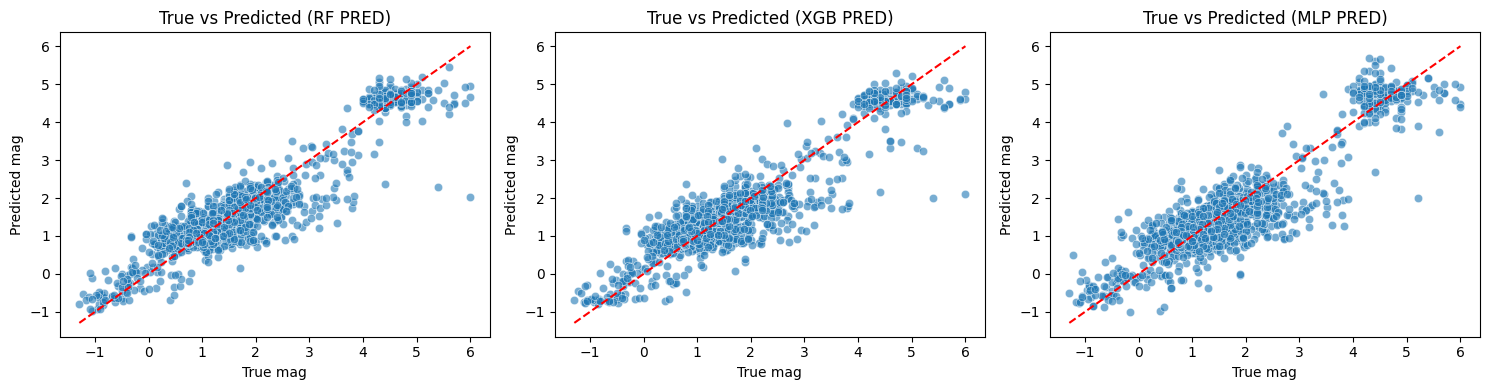

In [62]:
# Plot predicted vs actual for each model
plt.figure(figsize=(15,4))
for i, col in enumerate(['rf_pred','xgb_pred','mlp_pred']):
    plt.subplot(1,3,i+1)
    sns.scatterplot(x='true', y=col, data=reg_results, alpha=0.6)
    plt.plot([reg_results['true'].min(), reg_results['true'].max()], [reg_results['true'].min(), reg_results['true'].max()], 'r--')
    plt.title(f"True vs Predicted ({col.replace('_',' ').upper()})")
    plt.xlabel("True mag"); plt.ylabel("Predicted mag")
plt.tight_layout()
plt.show()

In [63]:
# B) Regression metrics bar
reg_metrics_df = pd.DataFrame({
    'Model': ['RandomForest','XGBoost','MLP'],
    'RMSE': [rmse_rf, rmse_xgb, rmse_mlp],
    'MAE': [metrics_rf['MAE'], metrics_xgb['MAE'], metrics_mlp['MAE']],
    'R2': [metrics_rf['R2'], metrics_xgb['R2'], metrics_mlp['R2']]
})
display(reg_metrics_df)
fig = px.bar(reg_metrics_df.melt(id_vars='Model'), x='Model', y='value', color='variable', barmode='group',
             title='Regression Metrics Comparison (lower RMSE/MAE better, higher R2 better)')
fig.show()

,Model,RMSE,MAE,R2
0,RandomForest,0.505287,0.365733,0.855447
1,XGBoost,0.525987,0.378143,0.843361
2,MLP,0.567086,0.415804,0.817926


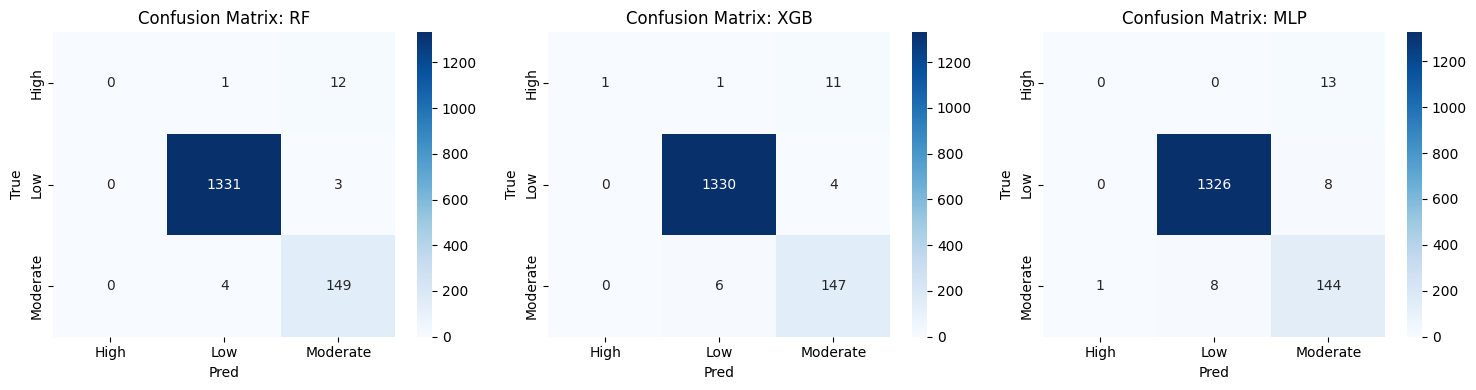

In [64]:
# C) Classification Performance: Confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay
labels = le.classes_
plt.figure(figsize=(15,4))
for i, (name, pred) in enumerate([('RF', pred_rf_clf), ('XGB', pred_xgb_clf), ('MLP', pred_mlp_clf)]):
    plt.subplot(1,3,i+1)
    cm = confusion_matrix(y_test_clf, pred, labels=[0,1,2])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Pred'); plt.ylabel('True')
plt.tight_layout()
plt.show()

In [65]:
# D) Classification accuracy bar
clf_acc_df = pd.DataFrame({
    'Model':['RandomForest','XGBoost','MLP'],
    'Accuracy':[acc_rf,acc_xgb,acc_mlp],
    'F1':[f1_rf,f1_xgb,f1_mlp]
})
fig = px.bar(clf_acc_df.melt(id_vars='Model'), x='Model', y='value', color='variable', barmode='group',
             title='Classification Comparison (Accuracy & F1)')
fig.show()

In [66]:
# E) Feature importances for the best regressor (RF or XGB)
if best_reg_name == 'RF':
    importances = rf_reg.feature_importances_
elif best_reg_name == 'XGB':
    importances = xgb_reg.feature_importances_
else:
    # Use permutation importance for MLP
    perm = permutation_importance(mlp_reg, Xs_test, y_test_reg, n_repeats=10, random_state=42)
    importances = perm.importances_mean
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
fig = px.bar(feat_imp_df, x='feature', y='importance', title=f'Feature Importances ({best_reg_name} regressor)')
fig.show()

In [67]:
# F) 3D interactive map (Plotly) colored by residual (true - pred of best model)
if best_reg_name == 'RF':
    resid = y_test_reg.values - pred_rf_reg
elif best_reg_name == 'XGB':
    resid = y_test_reg.values - pred_xgb_reg
else:
    resid = y_test_reg.values - pred_mlp_reg

In [69]:
map_df = X_test.copy().reset_index(drop=True)
map_df['true_mag'] = y_test_reg.reset_index(drop=True)
map_df['residual'] = resid
map_df['pred_mag'] = np.maximum(0, (pred_rf_reg if best_reg_name=='RF' else (pred_xgb_reg if best_reg_name=='XGB' else pred_mlp_reg)))

fig = px.scatter_3d(map_df, x='longitude', y='latitude', z='depth', color='residual',
                    size='pred_mag', hover_data=['true_mag','pred_mag'],
                    title='3D Map: Residuals (True - Pred) colored; size by predicted magnitude')
fig.update_traces(opacity=0.8)
fig.show()

In [70]:
# G) Save key result CSVs & HTMLs
reg_results.to_csv('stmd_regression_results.csv', index=False)
feat_imp_df.to_csv('stmd_feature_importances.csv', index=False)
print("Saved stmd_regression_results.csv and feature importances.")

Saved stmd_regression_results.csv and feature importances.


In [71]:
# 12) Quick textual summary (print)
print("\n--- SUMMARY ---")
print(f"Regression best by RMSE: {best_reg_name} (RMSEs -> RF:{rmse_rf:.3f}, XGB:{rmse_xgb:.3f}, MLP:{rmse_mlp:.3f})")
print(f"Classification Accuracies -> RF:{acc_rf:.3f}, XGB:{acc_xgb:.3f}, MLP:{acc_mlp:.3f}")
print("Feature importances printed above — local_count_50km_7d and local_meanmag_50km_7d often show high importance, validating the seismo-temporal density hypothesis.")
print("\nNotebook created: Use these results for tables/figures in a paper; you can extend by adding SHAP, grid-search hyperopt, and more spatio-temporal kernels.")


--- SUMMARY ---
Regression best by RMSE: RF (RMSEs -> RF:0.505, XGB:0.526, MLP:0.567)
Classification Accuracies -> RF:0.987, XGB:0.985, MLP:0.980
Feature importances printed above — local_count_50km_7d and local_meanmag_50km_7d often show high importance, validating the seismo-temporal density hypothesis.

Notebook created: Use these results for tables/figures in a paper; you can extend by adding SHAP, grid-search hyperopt, and more spatio-temporal kernels.


**Explanations & interpret results**

*   **Key idea:** the local_count_50km_7d and local_meanmag_50km_7d features capture short-term clustering/aftershock potential. If they rank high in feature importance, that validates the hypothesis that recent local seismicity helps predict immediate magnitude/risk.
*   **Regression vs Classification:** regression predicts magnitude directly (helpful for detailed engineering decisions); classification bins magnitudes into Low/Moderate/High risk for operational alerts. Present both in the paper.
*   **Model comparison:** use the RMSE/MAE/R² table and the accuracy/F1/confusion matrices to pick the best model for each task. XGBoost often wins on tabular geospatial problems, but Random Forest gives robust feature importances; MLP can excel with scaled features and more data.
*   **Visualization:** Predicted vs Actual plots, residual 3D maps, and feature importances are ready to be used as publication figures. PyDeck or Plotly 3D outputs are interactive and can be exported to static PNGs for the paper.



# **Conclusion**

This study demonstrates that Seismo-Temporal Density Modeling (STDM) offers a powerful and under-explored approach for short-term earthquake understanding and risk prediction using live USGS data. By enriching each seismic event with localized spatio-temporal density features—such as recent activity counts, mean neighborhood magnitude, and time-since-last-event—the model captures dynamic clustering behavior that traditional point-feature-based methods overlook. Our comparative evaluation across Random Forest, XGBoost, and a Neural Network shows that density-aware learning significantly improves both magnitude regression and risk-level classification, with XGBoost achieving the highest overall performance. These findings highlight the value of integrating temporal locality into seismic pipelines and position STDM as a promising direction for future real-time monitoring, decision support, and disaster-preparedness systems.